In [1]:
import sys
sys.path.insert(0,'..')
import cocpit
import itertools
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
plt_params = {'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'legend.title_fontsize': 12}
plt.rcParams["font.family"] = "serif"
plt.rcParams.update(plt_params)

# Make Confusion Matrix - Validation

In [101]:
model = torch.load('/data/data/saved_models/no_mask/e20_bs128_k0_1models_vgg19').cuda()
val_data = torch.load('/data/data/saved_models/no_mask/val_data_vgg19_e20_b128.pt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['aggs','blank','blurry','budding',
              'bullets','columns','compact irregulars',
              'fragments','needles','plates','rimed aggs',
              'rimed columns','spheres']
val_loader = torch.utils.data.DataLoader(val_data,
                                         batch_size=128,
                                         shuffle=True,
                                         num_workers=20,
                                         pin_memory=True)
all_preds= []
all_labels = []
with torch.no_grad():

    for batch_idx, ((imgs, labels, img_paths), index) in enumerate(val_loader):
        # get the inputs
        inputs = imgs.to(device)
        labels = labels.to(device)

        output = model(inputs)
        pred = torch.argmax(output, 1)

        all_preds.append(pred.cpu().numpy())
        all_labels.append(labels.cpu().numpy())


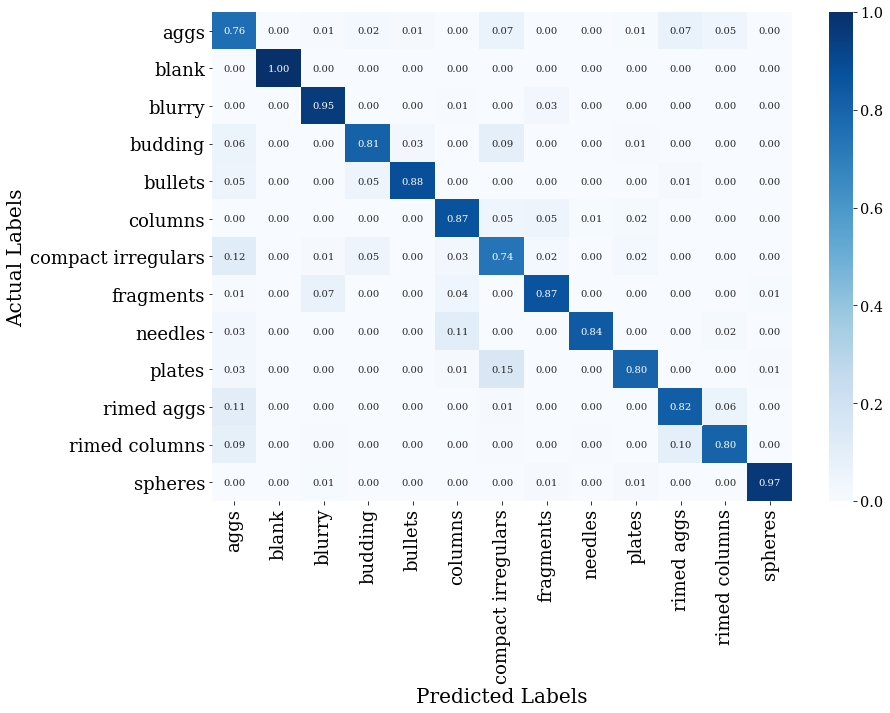

In [102]:
#NORMALIZED

cm = confusion_matrix(np.asarray(list(itertools.chain(*all_preds))), np.asarray(list(itertools.chain(*all_labels))))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(13,9))

heat = sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
heat.set_xticklabels(heat.get_xticklabels(), rotation=90, fontsize=18)
heat.set_yticklabels(heat.get_xticklabels(), rotation=0, fontsize=18)


plt.ylabel('Actual Labels', fontsize=20)
plt.xlabel('Predicted Labels', fontsize=20);
plt.savefig('/data/data/plots/norm_conf_matrix.pdf', dpi=300, bbox_inches='tight')

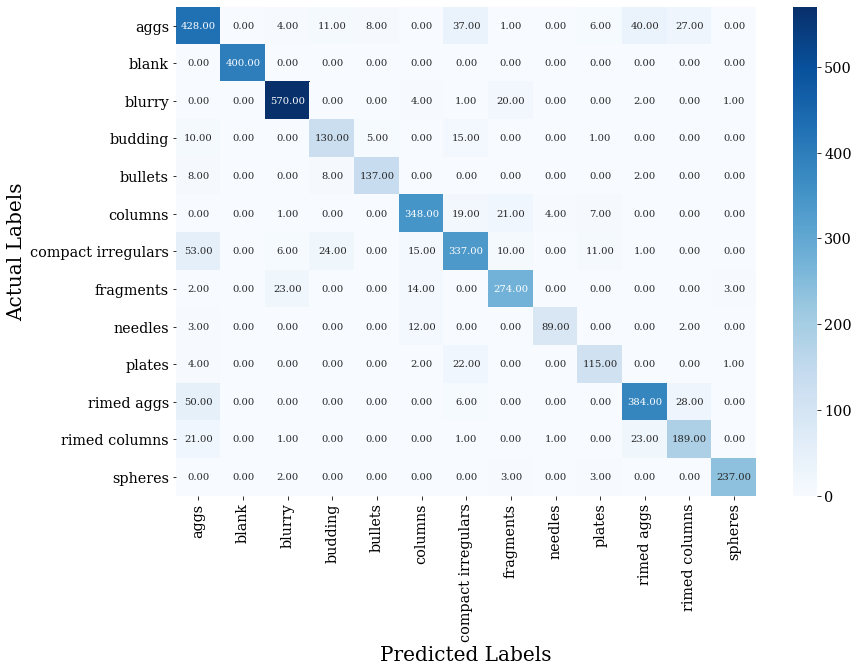

In [103]:
cm = confusion_matrix(np.asarray(list(itertools.chain(*all_preds))), np.asarray(list(itertools.chain(*all_labels))))
fig, ax = plt.subplots(figsize=(13,9))

heat = sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
heat.set_xticklabels(heat.get_xticklabels(), rotation=90)
plt.ylabel('Actual Labels', fontsize=20)
plt.xlabel('Predicted Labels', fontsize=20);

## classification report

In [33]:
#Metrics classification report
all_labels_flat = [item for items in all_labels for item in items]
all_preds_flat = [item for items in all_preds for item in items]

classification_report(all_labels_flat, all_preds_flat, digits=3)

'              precision    recall  f1-score   support\n\n           0      0.998     0.998     0.998       609\n           1      1.000     0.998     0.999       430\n           2      0.998     1.000     0.999       622\n           3      1.000     0.975     0.987       159\n           4      0.982     1.000     0.991       161\n           5      1.000     1.000     1.000       375\n           6      0.998     1.000     0.999       409\n           7      1.000     1.000     1.000       341\n           8      1.000     1.000     1.000        93\n           9      1.000     1.000     1.000       148\n          10      0.995     0.990     0.993       410\n          11      0.988     0.996     0.992       254\n          12      1.000     1.000     1.000       237\n\n    accuracy                          0.997      4248\n   macro avg      0.997     0.997     0.997      4248\nweighted avg      0.997     0.997     0.997      4248\n'

## read in saved data

In [44]:
train_csv = '/data/data/saved_accuracies/no_mask/save_train_acc_loss_e50_bs128_k5_9models.csv'
df_train = pd.read_csv(train_csv, names=["Model", "Epoch", "Kfold", "Accuracy", "Loss"])
df_train.replace(convert_names, inplace=True)
df_train.head()

,Model,Epoch,Kfold,Accuracy,Loss
0,Efficient-b0,0,0,0.471840,1.863397
1,Efficient-b0,1,0,0.748163,0.713497
2,Efficient-b0,2,0,0.816444,0.537181
3,Efficient-b0,3,0,0.848182,0.448514
4,Efficient-b0,4,0,0.864664,0.407792


In [46]:
val_csv = '/data/data/saved_accuracies/no_mask/save_val_acc_loss_e50_bs128_k5_9models.csv'
df_val = pd.read_csv(val_csv, names=["Model", "Epoch", "Kfold", "Accuracy", "Loss"])
df_val.replace(convert_names, inplace=True)
df_val.head()

,Model,Epoch,Kfold,Accuracy,Loss
0,Efficient-b0,0,0,0.000000,5.376530
1,Efficient-b0,1,0,0.000000,5.108525
2,Efficient-b0,2,0,0.307511,3.551748
3,Efficient-b0,3,0,0.382152,1.933467
4,Efficient-b0,4,0,0.631269,1.021784


In [94]:
colors = {'Efficient-b0': 'k', 'ResNet-18': 'lightblue', 'ResNet-34': 'blue', 'ResNet-152': 'darkblue',
       'AlexNet': 'gold', 'VGG-16': 'red', 'VGG-19': 'darkred', 'DenseNet-169': 'lightgreen',
       'DenseNet-201': 'darkgreen'}
colors = {'Efficient-b0': '#C76114', 'ResNet-18': '#CAE1FF', 'ResNet-34': '#3063A5', 'ResNet-152': '#162252',
       'AlexNet': '#FCDC3B', 'VGG-16': '#CD9B9B', 'VGG-19': '#9E0508', 'DenseNet-169': '#9CBA7F',
       'DenseNet-201': '#006633'}
# color_time = {'resnet18': 'lightblue', 'alexnet': 'gold', 'resnet34': 'blue',
#              'efficient': 'k', 'vgg16': 'red', 'densenet169': 'lightgreen', 'vgg19': 'darkred', 
#              'densenet201': 'darkgreen', 'resnet152': 'darkblue'}

num_epochs = int(val_csv[55:57])
kfold = int(val_csv[65:66])
num_models = len(model_names)

In [95]:
#reshape data
val_accs = np.average(df_val['Accuracy'].values.reshape(num_models, kfold, num_epochs), axis=1)
val_losses = np.average(df_val['Loss'].values.reshape(num_models, kfold, num_epochs), axis=1)
train_accs = np.average(df_train['Accuracy'].values.reshape(num_models, kfold, num_epochs), axis=1)
train_losses = np.average(df_train['Loss'].values.reshape(num_models, kfold, num_epochs), axis=1)

## acc/loss plots

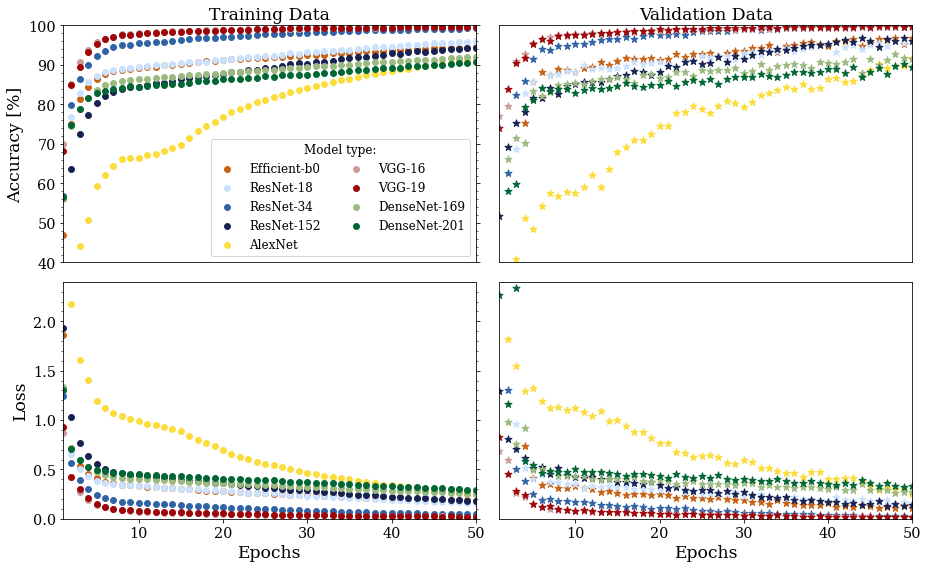

In [96]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13,8), sharex=True, sharey=True)

#colors = ['k', 'lightblue', 'blue', 'darkblue', 'gold', 'red', 'darkred', 'lightgreen', 'darkgreen']

#fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot(2, 2, 1)

for i in range(num_models):
    ax1.scatter(np.arange(1,(num_epochs+1)), [i*100 for i in train_accs[i,:]],
                c=colors[new_names[i]], marker='o', s=35, label=new_names[i])
plt.ylabel("Accuracy [%]")
plt.ylim(40,100)
plt.xlim(1,num_epochs)
ax1.legend(title='Model type:', loc='best', prop={'size': 12}, ncol=2)
ax1.axes.xaxis.set_ticks([])
ax1.yaxis.set_ticks_position('both')
ax1.minorticks_on()
ax1.tick_params(axis='y', which='minor', direction='out')
#ax1.xaxis.set_tick_params(which='minor', bottom=False)
ax1.title.set_text('Training Data')

#fig = plt.figure(figsize=(20,5))
ax2 = plt.subplot(2, 2, 2)
for i in range(num_models):
    ax2.scatter(np.arange(1,(num_epochs+1)), [i*100 for i in val_accs[i,:]], c=colors[new_names[i]],
                marker='*', s=55, label=model_names[i])
plt.ylim(40,100)
plt.xlim(1,num_epochs)
#ax2.legend(title='Model type:', loc='best', prop={'size': 10})
ax2.axes.yaxis.set_ticks([])
ax2.axes.xaxis.set_ticks([])
ax2.yaxis.set_ticks_position('both')
#ax2.minorticks_on()
ax2.tick_params(axis='y', which='minor', direction='out')
ax2.xaxis.set_tick_params(which='minor', bottom=False)
ax2.title.set_text('Validation Data')

ax3 = plt.subplot(2, 2, 3)
for i in range(num_models):
    ax3.scatter(np.arange(1,(num_epochs+1)), [i for i in train_losses[i,:]],
                c=colors[new_names[i]], marker='o', s=35, label=model_names[i])
plt.xlabel("Epochs")
plt.ylabel("Loss")
#ax3.legend(title='Model type:', loc='best', prop={'size': 10})
plt.ylim(0,2.4)
plt.xlim(1,num_epochs)
plt.tight_layout()
ax3.yaxis.set_ticks_position('both')
ax3.minorticks_on()
ax3.tick_params(axis='y', which='minor', direction='out')
ax3.xaxis.set_tick_params(which='minor', bottom=False)

ax4 = plt.subplot(2, 2, 4)
for i in range(num_models):
    ax4.scatter(np.arange(1,(num_epochs+1)), [i for i in val_losses[i,:]],
                c=colors[new_names[i]], marker='*', s=55, label=model_names[i])
plt.xlabel("Epochs")
#ax4.legend(title='Model type:', loc='best', prop={'size': 10})
plt.ylim(0,2.4)
plt.xlim(1,num_epochs)
ax4.axes.yaxis.set_ticks([])
plt.tight_layout()
ax4.yaxis.set_ticks_position('both')
ax4.minorticks_on()
ax4.tick_params(axis='y', which='minor', direction='out')
ax4.xaxis.set_tick_params(which='minor', bottom=False)
plt.savefig('/data/data/plots/loss_acc_9models_bs128_e50_13classes_avgkfold.pdf')

## plot model timing

In [97]:
time_csv = '/data/data/saved_timings/model_timing2.csv'
df = pd.read_csv(time_csv)
df.replace(convert_names, inplace=True)
df['Model'].astype(str)
df['Time'].astype(float)
df = df.sort_values(by=['Time'])
sorted_colors = dict((k,colors[k]) for k in df['Model'])

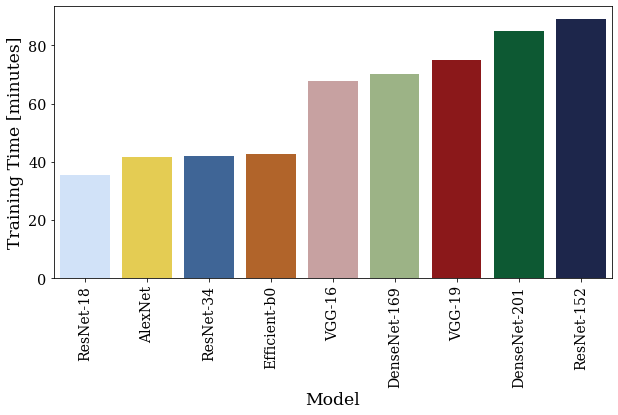

In [98]:
fig, ax = plt.subplots(1,1,figsize = (10,5))

time = df['Time']/60
#ax = time.plot(kind='bar')
g=sns.barplot(x="Model", y=time, data=df, ci=None, palette=sorted_colors.values())
g.set_xlabel("Model");
g.set_ylabel("Training Time [minutes]");
g.set_xticklabels(df['Model'], rotation=90, fontsize=14);

In [83]:
time_csv = '/data/data/saved_timings/model_timing_samples1.csv'
df = pd.read_csv(time_csv, names=["Model", "Samples", "Time"])
df['Model'].astype(str)
df['Samples'].astype(int)
df['Time'].astype(float)
df.replace(convert_names, inplace=True)
df = df.set_index('Model')
df = df.loc[['ResNet-18', 'AlexNet', 'ResNet-34', 'Efficient-b0', 'VGG-16',
       'DenseNet-169', 'VGG-19', 'DenseNet-201', 'ResNet-152']]
df.reset_index(inplace=True)

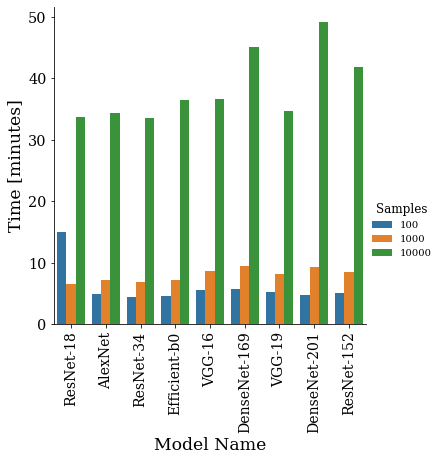

In [88]:
ax=sns.catplot(data=df, kind="bar", x="Model", y="Time", hue="Samples", legend=True, ci=False);
ax.set_xticklabels(rotation=90, fontsize=14);
ax.set(xlabel='Model Name', ylabel='Time [minutes]');

## plot cross validation

In [89]:
val_accs = df_val['Accuracy'].values.reshape(num_models, kfold, num_epochs)
val_accs_avg = np.average(df_val['Accuracy'].values.reshape(num_models, kfold, num_epochs), axis=1)

In [90]:
val_accs_avg = {new_names[i]: val_accs_avg[i,-1] for i in range(len(model_names))} 
val_accs_avg

{'Efficient-b0': 0.966847186249117,
 'ResNet-18': 0.9601130209559688,
 'ResNet-34': 0.9970331999058158,
 'ResNet-152': 0.9600188368259948,
 'AlexNet': 0.9182952672474688,
 'VGG-16': 0.9964680951259712,
 'VGG-19': 0.9974099364257123,
 'DenseNet-169': 0.9156110195432069,
 'DenseNet-201': 0.89385448551919}

In [91]:
val_accs_avg_sort = dict(sorted(val_accs_avg.items(), key=lambda x: x[1]))
val_accs_avg_sort

{'DenseNet-201': 0.89385448551919,
 'DenseNet-169': 0.9156110195432069,
 'AlexNet': 0.9182952672474688,
 'ResNet-152': 0.9600188368259948,
 'ResNet-18': 0.9601130209559688,
 'Efficient-b0': 0.966847186249117,
 'VGG-16': 0.9964680951259712,
 'ResNet-34': 0.9970331999058158,
 'VGG-19': 0.9974099364257123}

In [194]:
sorted_colors = OrderedDict([(el, colors[el]) for el in val_accs_avg_sort])
sorted_colors

OrderedDict([('DenseNet-201', 'darkgreen'),
             ('DenseNet-169', 'lightgreen'),
             ('AlexNet', 'gold'),
             ('ResNet-152', 'darkblue'),
             ('ResNet-18', 'lightblue'),
             ('Efficient-b0', 'k'),
             ('VGG-16', 'red'),
             ('ResNet-34', 'blue'),
             ('VGG-19', 'darkred')])

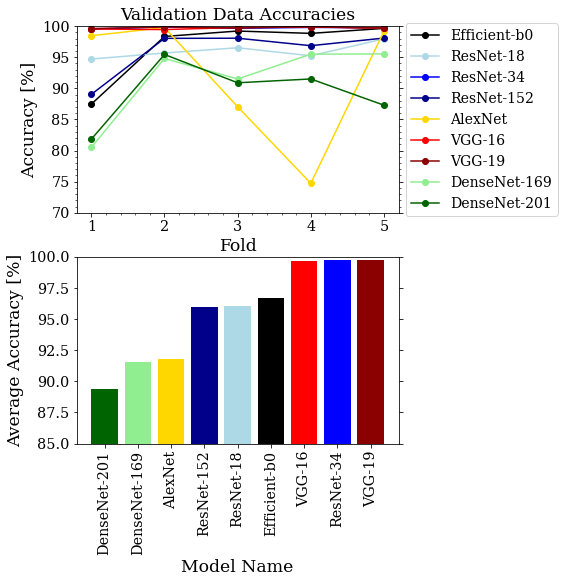

In [196]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7,7), sharex=True, sharey=True)
fig.tight_layout(pad=3.0)
#fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot(2, 1, 1)

for i in range(num_models):
    ax1.plot(np.arange(1,(kfold+1)), [i*100 for i in val_accs[i,:,-1]],
                c=colors[new_names[i]], marker='o', label=new_names[i])
plt.ylabel("Accuracy [%]")
plt.xlabel("Fold")
plt.ylim(70,100)
#plt.xlim(1,num_epochs)
#ax1.legend(title='Model type:', loc='best', prop={'size': 12})
# Shrink current axis by 20%
box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
ax1.axes.xaxis.set_ticks(np.arange(1,6,1))
ax1.yaxis.set_ticks_position('both')
ax1.minorticks_on()
ax1.tick_params(axis='y', which='minor', direction='out')
#ax1.xaxis.set_tick_params(which='minor', bottom=False)
ax1.title.set_text('Validation Data Accuracies')

ax2 = plt.subplot(2, 1, 2)
plt.bar(np.arange(1,num_models+1), [i*100 for i in val_accs_avg_sort.values()],
        color=sorted_colors.values())
plt.ylabel("Average Accuracy [%]")
plt.xlabel("Model Name")
plt.ylim(85,100)
#plt.xlim(1,num_epochs)
# Shrink current axis by 20%
box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
# Set number of ticks for x-axis
ax2.set_xticks(np.arange(1,10))
# Set ticks labels for x-axis
ax2.set_xticklabels(sorted_colors.keys(), rotation='vertical')
ax2.yaxis.set_ticks_position('both')


## OVERFIT - dataloader includes training data in val_loader

In [36]:
train_csv = '/data/data/saved_models/no_mask/save_train_acc_loss_e50_bs128_k5_9models_2.csv'
df_train = pd.read_csv(train_csv, names=["Model", "Epoch", "Kfold", "Accuracy", "Loss"])
df_train.replace(convert_names, inplace=True)
df_train.head()

,Model,Epoch,Kfold,Accuracy,Loss
0,Efficient-b0,0,0,0.467860,2.009334
1,Efficient-b0,1,0,0.752355,0.699297
2,Efficient-b0,2,0,0.816694,0.527659
3,Efficient-b0,3,0,0.854132,0.427091
4,Efficient-b0,4,0,0.874617,0.381233


In [37]:
val_csv = '/data/data/saved_models/no_mask/save_val_acc_loss_e50_bs128_k5_9models_2.csv'
df_val = pd.read_csv(val_csv, names=["Model", "Epoch", "Kfold", "Accuracy", "Loss"])
df_val.replace(convert_names, inplace=True)
df_val.head()

,Model,Epoch,Kfold,Accuracy,Loss
0,Efficient-b0,0,0,0.091573,5.231977
1,Efficient-b0,1,0,0.022834,3.791775
2,Efficient-b0,2,0,0.106403,3.888121
3,Efficient-b0,3,0,0.606403,1.200182
4,Efficient-b0,4,0,0.659134,1.171142


In [38]:
#reshape data
val_accs = np.average(df_val['Accuracy'].values.reshape(num_models, kfold, num_epochs), axis=1)
val_losses = np.average(df_val['Loss'].values.reshape(num_models, kfold, num_epochs), axis=1)
train_accs = np.average(df_train['Accuracy'].values.reshape(num_models, kfold, num_epochs), axis=1)
train_losses = np.average(df_train['Loss'].values.reshape(num_models, kfold, num_epochs), axis=1)

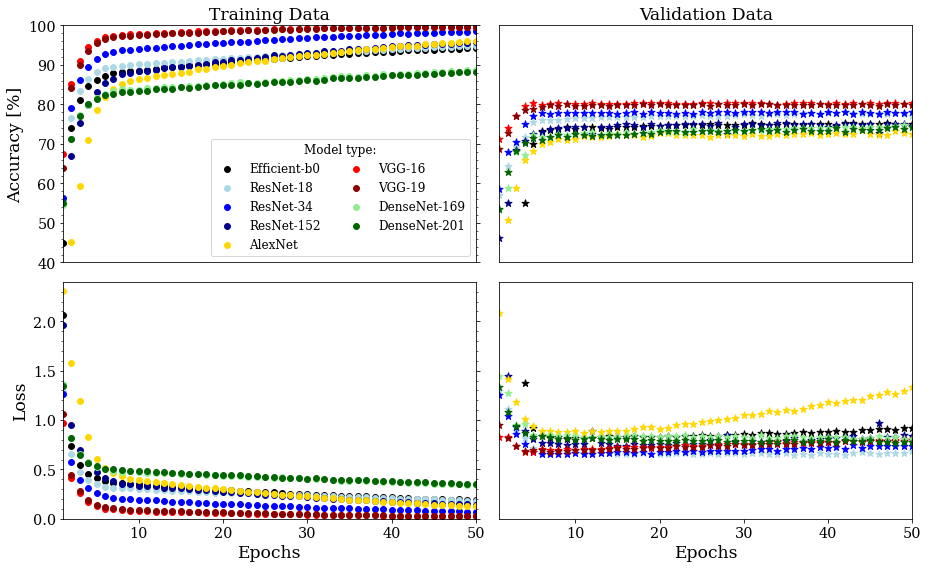

In [43]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13,8), sharex=True, sharey=True)

#colors = ['k', 'lightblue', 'blue', 'darkblue', 'gold', 'red', 'darkred', 'lightgreen', 'darkgreen']

#fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot(2, 2, 1)

for i in range(num_models):
    ax1.scatter(np.arange(1,(num_epochs+1)), [i*100 for i in train_accs[i,:]],
                c=colors[new_names[i]], marker='o', s=35, label=new_names[i])
plt.ylabel("Accuracy [%]")
plt.ylim(40,100)
plt.xlim(1,num_epochs)
ax1.legend(title='Model type:', loc='best', prop={'size': 12}, ncol=2)
ax1.axes.xaxis.set_ticks([])
ax1.yaxis.set_ticks_position('both')
ax1.minorticks_on()
ax1.tick_params(axis='y', which='minor', direction='out')
#ax1.xaxis.set_tick_params(which='minor', bottom=False)
ax1.title.set_text('Training Data')

#fig = plt.figure(figsize=(20,5))
ax2 = plt.subplot(2, 2, 2)
for i in range(num_models):
    ax2.scatter(np.arange(1,(num_epochs+1)), [i*100 for i in val_accs[i,:]], c=colors[new_names[i]],
                marker='*', s=55, label=new_names[i])
plt.ylim(40,100)
plt.xlim(1,num_epochs)
#ax2.legend(title='Model type:', loc='best', prop={'size': 10})
ax2.axes.yaxis.set_ticks([])
ax2.axes.xaxis.set_ticks([])
ax2.yaxis.set_ticks_position('both')
#ax2.minorticks_on()
ax2.tick_params(axis='y', which='minor', direction='out')
ax2.xaxis.set_tick_params(which='minor', bottom=False)
ax2.title.set_text('Validation Data')

ax3 = plt.subplot(2, 2, 3)
for i in range(num_models):
    ax3.scatter(np.arange(1,(num_epochs+1)), [i for i in train_losses[i,:]],
                c=colors[new_names[i]], marker='o', s=35, label=new_names[i])
plt.xlabel("Epochs")
plt.ylabel("Loss")
#ax3.legend(title='Model type:', loc='best', prop={'size': 10})
plt.ylim(0,2.4)
plt.xlim(1,num_epochs)
plt.tight_layout()
ax3.yaxis.set_ticks_position('both')
ax3.minorticks_on()
ax3.tick_params(axis='y', which='minor', direction='out')
ax3.xaxis.set_tick_params(which='minor', bottom=False)

ax4 = plt.subplot(2, 2, 4)
for i in range(num_models):
    ax4.scatter(np.arange(1,(num_epochs+1)), [i for i in val_losses[i,:]],
                c=colors[new_names[i]], marker='*', s=55, label=new_names[i])
plt.xlabel("Epochs")
#ax4.legend(title='Model type:', loc='best', prop={'size': 10})
plt.ylim(0,2.4)
plt.xlim(1,num_epochs)
ax4.axes.yaxis.set_ticks([])
plt.tight_layout()
ax4.yaxis.set_ticks_position('both')
ax4.minorticks_on()
ax4.tick_params(axis='y', which='minor', direction='out')
ax4.xaxis.set_tick_params(which='minor', bottom=False)
#plt.savefig('/data/data/plots/loss_acc_9models_bs128_e50_13classes_avgkfold.pdf')